# 1. Imports

In [1]:
# Required Imports
import re
import numpy as np
import pandas as pd
from pprint import pprint
import multiprocessing
import nltk

In [2]:
# Gensim for text preprocessing and LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

C:\Users\dkushwaha\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# spacy for lemmatization ans Stemming
import spacy

In [4]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Suppress all the warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Latent Dirichlet Allocation (LDA), using all CPU cores to parallelize and speed up model training
cores = multiprocessing.cpu_count()

# 2. Load Data

In [7]:
# Read the data set from training file => train.csv
df = pd.read_csv('train.csv', encoding='latin1')

In [8]:
# Check the loaded data 
df.head(2)

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman


In [9]:
# For LDA, we are only concerned with the text reviews
# therefore we will be selecting 'reviews.text' column as training data
# Converting data to a list for further text preprocessing
data = df['reviews.text'].tolist()

In [10]:
# Print the number of rows/ elements in list
len(data)

34660

# 3. Preprocess Data

In [11]:
# Remove new line characters
data = [re.sub('\s+', ' ', str(sent)) for sent in data]

In [12]:
# print the first element of the list
data[:1]

['This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.']

In [13]:
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [14]:
# print the first element of the list
data[:1]

['This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.']

In [15]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [16]:
# NLTK and Spacy Stop words
# The set of NLTK stopwords is limied.
# So we are adding the stopwords available in Spacy library with NLTK library to make a comprehensive set of stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
stop_words = list(set(stop_words + list(spacy_stopwords)))

In [17]:
# Check the total number of stop words in stop_words list
len(stop_words)

361

In [18]:
# function to convert each para into tokens after preprocessing
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [19]:
# clean and tokenize the data set
data_words = list(sent_to_words(data))

In [20]:
# Check the first element of preprocessed and tokenized list
data_words[:1]

[['this',
  'product',
  'so',
  'far',
  'has',
  'not',
  'disappointed',
  'my',
  'children',
  'love',
  'to',
  'use',
  'it',
  'and',
  'like',
  'the',
  'ability',
  'to',
  'monitor',
  'control',
  'what',
  'content',
  'they',
  'see',
  'with',
  'ease']]

In [21]:
# Function to remove stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [22]:
# Removing the reviews which has less than 10 words in the review.
# Output is the reduced list
data_reduced = [[x for x in data_words_1] for data_words_1 in data_words if len(data_words_1) > 10]

In [23]:
# Print the number of rows/ elements in reduced dataset/list
len(data_reduced)

30273

In [24]:
# Create a list of sentences using tokenised words to be used in Final Results
data_reduced_sent = [" ".join(y) for y in data_reduced]

In [25]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_reduced)

In [26]:
# Check the training data with stop words removed
data_words_nostops[:1]

[['product',
  'far',
  'disappointed',
  'children',
  'love',
  'use',
  'like',
  'ability',
  'monitor',
  'control',
  'content',
  'ease']]

In [27]:
# Calculate the frequency of each word in dataset
from collections import defaultdict
frequency = defaultdict(int)
for text in data_words_nostops:
    for token in text:
        frequency[token] += 1

In [28]:
# Print the list of most frequent occuring words
import operator
most_frq = sorted(frequency.items(),key = operator.itemgetter(1), reverse=True)
most_frq[:30] # Top 10 most frquent words

[('great', 10330),
 ('tablet', 8345),
 ('use', 7316),
 ('love', 6054),
 ('easy', 5758),
 ('amazon', 5569),
 ('kindle', 5162),
 ('bought', 4844),
 ('fire', 4688),
 ('good', 4474),
 ('price', 3756),
 ('like', 3663),
 ('tv', 3176),
 ('product', 2971),
 ('echo', 2857),
 ('read', 2728),
 ('music', 2714),
 ('works', 2706),
 ('alexa', 2597),
 ('apps', 2554),
 ('kids', 2537),
 ('books', 2486),
 ('loves', 2451),
 ('reading', 2362),
 ('device', 2308),
 ('best', 2250),
 ('time', 2218),
 ('games', 2209),
 ('buy', 2204),
 ('screen', 2157)]

In [29]:
# Selectively creating a list of most frequent words that are irrelevant for the topic models
most_frq_words = ['great','use','love',
                  'easy','good','bought',
                  'like','loves','best',
                  'buy']

In [30]:
# add the the most frequent words to the stopwords list from the above analysis
stop_words.extend(most_frq_words)
len(stop_words) # Check the length of updated stopwords list

371

In [31]:
# Again remove words from corpus using updated list
data_words_nostops = remove_stopwords(data_words_nostops)

In [32]:
# Print the first element of data list after removal of most frequent words
data_words_nostops[:1]

[['product',
  'far',
  'disappointed',
  'children',
  'ability',
  'monitor',
  'control',
  'content',
  'ease']]

In [33]:
# Build the bigram model
bigram = gensim.models.Phrases(data_words_nostops, min_count=1, threshold=100) # higher threshold fewer phrases.

In [34]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [35]:
# Function to make bigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [36]:
# Import lemmatizer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [37]:
def lemmatization_stemming(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([lemmatizer.lemmatize(token.lemma_) for token in doc if token.pos_ in allowed_postags and len(token) > 1])
    return texts_out

In [38]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [39]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization_stemming(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [40]:
# Print first element of preprocessed data list after lemmatization 
print(data_lemmatized[:1])

[['product', 'far', 'disappointed', 'child', 'ability', 'monitor', 'control', 'content', 'ease']]


In [41]:
# create a word to index mapping with preprocessed data list
id2word = corpora.Dictionary(data_lemmatized)

In [42]:
# Create a list of words with POS as Adjective
Adj = []
for i in range(11924):
    if nltk.pos_tag([id2word[i]])[0][1] == 'JJ':
        Adj.append(id2word[i])

In [43]:
# print first 10 elements from the list of adjectives extracted
Adj[:10]

['disappointed',
 'inexpensive',
 'able',
 'futuristic',
 'nice',
 'additional',
 'basic',
 'grand',
 'little',
 'big']

In [45]:
# add the the Adjectives to the stopwords list from the above analysis
# Because the Adjectives are non relevant for topic models
stop_words.extend(Adj)

In [46]:
# Update the preprocessed data list
data_lemmatized = remove_stopwords(data_lemmatized)

In [47]:
# update the word to index mapping with updated preprocessed data list
id2word = corpora.Dictionary(data_lemmatized)

In [48]:
# Term Document Frequency
# Create Corpus
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [49]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ability', 1),
  ('child', 1),
  ('content', 1),
  ('control', 1),
  ('ease', 1),
  ('far', 1),
  ('monitor', 1),
  ('product', 1)]]

# 4. Training and Visualisation

In [50]:
# Build LDA model
# for Single core processing use :
# lda_model = gensim.models.ldamodel.LdaModel()
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       random_state=100,
                                       num_topics=3,
                                       passes=20,
                                       per_word_topics=True,
                                       workers=cores)

In [51]:
# Print the Keyword in the 3 topics
pprint(lda_model.print_topics(num_words=10))
doc_lda = lda_model[corpus]

[(0,
  '0.079*"tablet" + 0.034*"price" + 0.028*"kid" + 0.023*"game" + 0.021*"gift" '
  '+ 0.021*"app" + 0.020*"purchase" + 0.018*"year" + 0.015*"play" + '
  '0.015*"product"'),
 (1,
  '0.053*"kindle" + 0.038*"read" + 0.026*"book" + 0.019*"screen" + '
  '0.017*"light" + 0.012*"fire" + 0.011*"reader" + 0.010*"paperwhite" + '
  '0.009*"device" + 0.008*"amazon"'),
 (2,
  '0.031*"tv" + 0.022*"fire" + 0.022*"amazon" + 0.022*"echo" + 0.019*"music" + '
  '0.019*"alexa" + 0.017*"work" + 0.015*"device" + 0.012*"product" + '
  '0.010*"app"')]


In [52]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -6.588497023808975


In [53]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')

In [54]:
# Print the coherence values
coherence_model_lda.get_coherence()

0.5378044864156383

In [55]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.190552 -0.040905       1        1  38.771473
0      0.131920 -0.139080       2        1  31.128962
1      0.058632  0.179985       3        1  30.099566, topic_info=     Category         Freq         Term        Total  loglift  logprob
16    Default  8245.000000       tablet  8245.000000  30.0000  30.0000
104   Default  5163.000000       kindle  5163.000000  29.0000  29.0000
299   Default  3822.000000           tv  3822.000000  28.0000  28.0000
91    Default  4099.000000         read  4099.000000  27.0000  27.0000
254   Default  2758.000000          kid  2758.000000  26.0000  26.0000
69    Default  3676.000000        price  3676.000000  25.0000  25.0000
116   Default  2314.000000         game  2314.000000  24.0000  24.0000
734   Default  2679.000000         echo  2679.000000  23.0000  23.0000
10    Default  2093.000000         gift  2093.000000  22.0000  22.0000
98    Default  3028.000000         book  3028.000000  21.0000  21.0000
138   Default  2383.000000        music  2383.000000  20.0000  20.0000
604   Default  2355.000000        alexa  2355.000000  19.0000  19.0000
47    Default  2059.000000       screen  2059.000000  18.0000  18.0000
190   Default  2002.000000         year  2002.000000  17.0000  17.0000
89    Default  2193.000000        light  2193.000000  16.0000  16.0000
260   Default  1115.000000     christma  1115.000000  15.0000  15.0000
388   Default  1096.000000          son  1096.000000  14.0000  14.0000
107   Default  1052.000000       reader  1052.000000  13.0000  13.0000
61    Default  1045.000000     daughter  1045.000000  12.0000  12.0000
117   Default  2731.000000         play  2731.000000  11.0000  11.0000
720   Default   914.000000   paperwhite   914.000000  10.0000  10.0000
1068  Default  1115.000000        stick  1115.000000   9.0000   9.0000
295   Default  1111.000000        sound  1111.000000   8.0000   8.0000
473   Default  1050.000000          box  1050.000000   7.0000   7.0000
693   Default  1035.000000          ask  1035.000000   6.0000   6.0000
296   Default  1005.000000      speaker  1005.000000   5.0000   5.0000
44    Default  1202.000000        prime  1202.000000   4.0000   4.0000
127   Default  3524.000000          app  3524.000000   3.0000   3.0000
101   Default  2821.000000       device  2821.000000   2.0000   2.0000
229   Default   741.000000       charge   741.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
676    Topic3   237.202393  lightweight   241.311340   1.1835  -6.0007
318    Topic3   206.045166          bed   210.207962   1.1807  -6.1415
91     Topic3  3658.137207         read  4099.727051   1.0867  -3.2649
47     Topic3  1808.608765       screen  2059.621582   1.0707  -3.9693
536    Topic3   471.391571      battery   503.436646   1.1349  -5.3139
98     Topic3  2536.512939         book  3028.294189   1.0235  -3.6311
147    Topic3   372.941895        carry   398.268097   1.1350  -5.5482
315    Topic3   470.119598      version   515.218079   1.1091  -5.3166
171    Topic3   784.394714      reading   902.503113   1.0604  -4.8047
612    Topic3   300.776642        touch   320.639709   1.1367  -5.7632
89     Topic3  1642.654419        light  2193.227051   0.9116  -4.0655
133    Topic3   224.916351         card   235.203552   1.1559  -6.0539
137    Topic3   385.609772       memory   459.778107   1.0247  -5.5148
87     Topic3   742.324646         size  1160.011353   0.7543  -4.8598
417    Topic3   411.630341      replace   541.306763   0.9268  -5.4495
572    Topic3   261.358124   resolution   293.807098   1.0836  -5.9037
29     Topic3   349.447205         feel   457.425293   0.9314  -5.6133
216    Topic3   460.173431         long   733.829102   0.7340  -5.3380
101    Topic3   890.346130       device  2821.555908   0.0472  -4.6780
30     Topic3  1108.020508         fire  4899.172852  -0.2858  -4.

In [56]:
# Finding the dominant topic in each sentence
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel.get_document_topics(corpus, minimum_probability=0.0)):
        
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([ sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [57]:
# Finding the dominant topic in each review
df_topic_sents_keywords = format_topics_sentences(lda_model, corpus, data_reduced_sent)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No','Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [58]:
# Save the output file to disc
df_dominant_topic.to_csv('Final_results_train.csv')

# 5. Validation

In [59]:
# Read test file
df_test = pd.read_csv('test.csv', encoding='latin1')

In [60]:
# Clean, preprocess and get model predictions
sentence_test = df_test['reviews.text'].tolist()
sentence_test = [re.sub('\s+', ' ', sent) for sent in sentence_test]
sentence_test = [re.sub("\'", "", sent) for sent in sentence_test]
sent_words_test = list(sent_to_words(sentence_test))
sent_words_nostops_test = remove_stopwords(sent_words_test)
sent_words_bigrams_test = make_bigrams(sent_words_nostops_test)
sent_lemmatized_test = lemmatization_stemming(sent_words_bigrams_test, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
id2word_test = corpora.Dictionary(sent_lemmatized_test)
ADJ_test = []
for i in range(3973):
    if nltk.pos_tag([id2word_test[i]])[0][1] == 'JJ':
        ADJ_test.append(id2word_test[i])
stop_words.extend(ADJ_test)
sent_lemmatized_test = remove_stopwords(sent_lemmatized_test)
id2word_test = corpora.Dictionary(sent_lemmatized_test)
corpus_test = [id2word.doc2bow(text) for text in sent_lemmatized_test]
ls = lda_model.get_document_topics(corpus,minimum_probability=0.00)

In [61]:
# Create sentences to be used for results csv
data_reduced_sent_test = [" ".join(y) for y in sent_words_test]

In [62]:
df_topic_sents_keywords = format_topics_sentences(lda_model, corpus_test, data_reduced_sent_test)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No','Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic.to_csv('Final_results_test.csv')

# 6. Finding Optimal no. of Topics

In [63]:
# find the optimal number of topics for LDA
def compute_coherence_values(dictionary, corpus, texts, start=1, limit = 8, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print("Training with {} number of Topics.".format(num_topics))
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics,
                                                random_state=None,
                                                update_every=1,
                                                chunksize=3466,
                                                passes=20,
                                                alpha='auto',
                                                eta='auto',
                                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [64]:
# create multiple models with variation in number of topics
# can take a long time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus,texts=data_lemmatized, start=1, limit=6, step=1)

Training with 1 number of Topics.
Training with 2 number of Topics.
Training with 3 number of Topics.
Training with 4 number of Topics.
Training with 5 number of Topics.


[0.3002683690367215, 0.45649382393169685, 0.5836549864504846, 0.6479309853227269, 0.596624979990344]


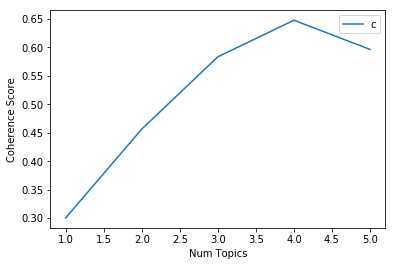

In [65]:
# Show graph
print(coherence_values)
limit = 6; start=1; step=1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [66]:
# Print the coherence scores for all the models
for m, cv in zip(x, coherence_values):
      print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.3003
Num Topics = 2  has Coherence Value of 0.4565
Num Topics = 3  has Coherence Value of 0.5837
Num Topics = 4  has Coherence Value of 0.6479
Num Topics = 5  has Coherence Value of 0.5966


In [67]:
# Select the optimal model and print the topics
# Analysis shows the optimal model is at with 4 topics i.e Index 3 of the model list
optimal_model = model_list[3] # Use the index of the model with highest Coherence value
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.074*"tablet" + 0.036*"price" + 0.036*"purchase" + 0.031*"product" + '
  '0.028*"kid" + 0.022*"gift" + 0.021*"work" + 0.021*"game" + 0.021*"year" + '
  '0.020*"recommend"'),
 (1,
  '0.056*"tv" + 0.052*"fire" + 0.041*"amazon" + 0.031*"app" + 0.020*"work" + '
  '0.019*"device" + 0.016*"stick" + 0.016*"watch" + 0.016*"box" + '
  '0.014*"prime"'),
 (2,
  '0.069*"kindle" + 0.055*"read" + 0.039*"book" + 0.025*"light" + '
  '0.021*"screen" + 0.014*"reader" + 0.013*"paperwhite" + 0.012*"reading" + '
  '0.011*"dot" + 0.010*"charge"'),
 (3,
  '0.046*"echo" + 0.041*"alexa" + 0.040*"music" + 0.035*"play" + 0.020*"home" '
  '+ 0.019*"sound" + 0.018*"ask" + 0.017*"speaker" + 0.015*"thing" + '
  '0.015*"fun"')]


In [68]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.068293  0.047345       1        1  28.655764
1     -0.025283 -0.282658       2        1  28.641150
2      0.218472  0.106573       3        1  21.677958
3     -0.261482  0.128740       4        1  21.025137, topic_info=     Category         Freq             Term        Total  loglift  logprob
16    Default  6712.000000           tablet  6712.000000  30.0000  30.0000
104   Default  4763.000000           kindle  4763.000000  29.0000  29.0000
299   Default  5099.000000               tv  5099.000000  28.0000  28.0000
91    Default  3772.000000             read  3772.000000  27.0000  27.0000
30    Default  4814.000000             fire  4814.000000  26.0000  26.0000
734   Default  3109.000000             echo  3109.000000  25.0000  25.0000
604   Default  2765.000000            alexa  2765.000000  24.0000  24.0000
138   Default  2702.000000            music  2702.000000  23.0000  23.0000
98    Default  2712.000000             book  2712.000000  22.0000  22.0000
69    Default  3328.000000            price  3328.000000  21.0000  21.0000
117   Default  2317.000000             play  2317.000000  20.0000  20.0000
127   Default  2864.000000              app  2864.000000  19.0000  19.0000
56    Default  4345.000000           amazon  4345.000000  18.0000  18.0000
254   Default  2550.000000              kid  2550.000000  17.0000  17.0000
10    Default  2017.000000             gift  2017.000000  16.0000  16.0000
86    Default  4023.000000         purchase  4023.000000  15.0000  15.0000
190   Default  1930.000000             year  1930.000000  14.0000  14.0000
89    Default  2269.000000            light  2269.000000  13.0000  13.0000
157   Default  1344.000000             home  1344.000000  12.0000  12.0000
295   Default  1242.000000            sound  1242.000000  11.0000  11.0000
116   Default  2086.000000             game  2086.000000  10.0000  10.0000
1068  Default  1491.000000            stick  1491.000000   9.0000   9.0000
693   Default  1188.000000              ask  1188.000000   8.0000   8.0000
47    Default  1858.000000           screen  1858.000000   7.0000   7.0000
53    Default  1432.000000            watch  1432.000000   6.0000   6.0000
473   Default  1416.000000              box  1416.000000   5.0000   5.0000
296   Default  1108.000000          speaker  1108.000000   4.0000   4.0000
43    Default  1277.000000            movie  1277.000000   3.0000   3.0000
7     Default  4036.000000          product  4036.000000   2.0000   2.0000
129   Default   998.000000              fun   998.000000   1.0000   1.0000
...       ...          ...              ...          ...      ...      ...
2013   Topic4   181.446091          kitchen   181.725098   1.5579  -5.9099
4932   Topic4   179.608887  home_automation   179.886612   1.5579  -5.9200
3289   Topic4   166.380692          pandora   166.657104   1.5578  -5.9965
7823   Topic4   162.329575             siri   162.603119   1.5578  -6.0212
2208   Topic4   150.835571            alarm   151.109222   1.5576  -6.0946
810    Topic4   147.218124          morning   147.494370   1.5576  -6.1189
1107   Topic4   142.803635             loud   143.079102   1.5575  -6.1493
707    Topic4   139.863998          request   140.136444   1.5575  -6.1701
788    Topic4   324.970245             cool   325.645782   1.5574  -5.3271
7811   Topic4   123.776649       thermostat   124.045616   1.5573  -6.2923
157    Topic4  1339.986572             home  1344.051636   1.5564  -3.9104
1138   Topic4   285.835754             hear   286.755402   1.5562  -5.4554
829    Topic4   262.843964             talk   263.745514   1.5560  -5.5393
3      Topic4   896.120789          control   953.876587   1.4970  -4.3127
1376   Topic4   436.700592              tap   461.968658   1.5032  -5.0316
434    Topic4   335.518066        bluetooth   354.607666   1.5041  -5.2951
858    Topic4   719.471008       

In [69]:
# Keep Machine Learning :D